In [13]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_nsclc_miRNAs.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape
print "mirna_normal_df.shape", mirna_normal_df.shape
print 'validated_miRNAs.shape', validated_miRNAs.shape

X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882)
mirna_normal_df.shape (46, 1882)
validated_miRNAs.shape (110, 1)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

In [14]:
from sklearn import preprocessing

X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

# Scale miRNA expressions to unit variance
X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X_normal_vs_I = X_scaler.transform(X_normal_vs_I)
X_normal_vs_II = X_scaler.transform(X_normal_vs_II)
X_normal_vs_III = X_scaler.transform(X_normal_vs_III)
X_normal_vs_IV = X_scaler.transform(X_normal_vs_IV)
X = X_scaler.transform(X)

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


In [37]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

print Y_normal_vs_I.value_counts()
print Y_normal_vs_II.value_counts()
print Y_normal_vs_III.value_counts()
print Y_normal_vs_IV.value_counts()

mirna_list 1881
validated_miRNAs 110
number of validated miRNAs in list of all miRNAs 109
Stage I    277
normal      46
Name: pathologic_stage, dtype: int64
Stage II    121
normal       46
Name: pathologic_stage, dtype: int64
Stage III    84
normal       46
Name: pathologic_stage, dtype: int64
normal      46
Stage IV    24
Name: pathologic_stage, dtype: int64


## Perform classification for normal vs Stage I, Stage II, Stage III, and Stage IV

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import numpy as np

X_normal_vs_I_train, X_normal_vs_I_test, Y_normal_vs_I_train, Y_normal_vs_I_test = \
    train_test_split(X_normal_vs_I, Y_normal_vs_I, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_II_train, X_normal_vs_II_test, Y_normal_vs_II_train, Y_normal_vs_II_test = \
    train_test_split(X_normal_vs_II, Y_normal_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_III_train, X_normal_vs_III_test, Y_normal_vs_III_train, Y_normal_vs_III_test = \
    train_test_split(X_normal_vs_III, Y_normal_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_IV_train, X_normal_vs_IV_test, Y_normal_vs_IV_train, Y_normal_vs_IV_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


normal_vs_I = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_II = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_III = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
normal_vs_IV = linear_model.LogisticRegression(C=100.1, penalty='l1', fit_intercept=False)
print normal_vs_I.fit(X_normal_vs_I_train, Y_normal_vs_I_train)
print normal_vs_II.fit(X_normal_vs_II_train, Y_normal_vs_II_train)
print normal_vs_III.fit(X_normal_vs_III_train, Y_normal_vs_III_train)
print normal_vs_IV.fit(X_normal_vs_IV_train, Y_normal_vs_IV_train)

# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100.1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,

## Show number of candidate miRNAs, top miRNAs based on coefficient, and percentage of known miRNA

In [39]:
from src.utils.validate_candidate_miRNAs import percent_candidate_in_validated as pciv
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV], 
                       ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})
    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    print "Percentage of known NSCLC miRNAs:", pciv(df['mirna'].tolist(), validated_miRNAs)
    print set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    
    results.append(df)


normal_vs_I
Non-zero coef: 129
     coefficient          mirna
93      1.133849  hsa-mir-486-2
123     0.963129   hsa-mir-7108
20      0.785689    hsa-mir-143
75      0.717223   hsa-mir-4529
55      0.501423   hsa-mir-3916
124     0.501420   hsa-mir-7704
     coefficient         mirna
106    -0.899259   hsa-mir-628
114    -0.862309  hsa-mir-6787
7      -0.695066  hsa-mir-106a
34     -0.681934    hsa-mir-21
97     -0.678753  hsa-mir-5579
23     -0.652492   hsa-mir-182
Percentage of known NSCLC miRNAs: 0.181818181818
set(['hsa-mir-200b', 'hsa-mir-378a', 'hsa-mir-21', 'hsa-mir-106a', 'hsa-mir-135b', 'hsa-mir-218-1', 'hsa-mir-34a', 'hsa-mir-182', 'hsa-mir-148a', 'hsa-mir-199b', 'hsa-mir-186', 'hsa-mir-143', 'hsa-mir-625', 'hsa-mir-199a-2', 'hsa-mir-1-1', 'hsa-mir-199a-1', 'hsa-mir-7-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7a-1']) 20

normal_vs_II
Non-zero coef: 126
     coefficient          mirna
73      0.693833   hsa-mir-4689
122     0.660391   hsa-mir-7108
79      0.658154  hsa-mi

AttributeError: 'LogisticRegression' object has no attribute 'scores_'

In [40]:
for i in range(len(results)):
    for j in range(len(results)):
        print '\n', "Stage "+str(i+1)+' - Stage '+str(j+1), ' : ',len(set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist()))
        # print set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist())


Stage 1 - Stage 1  :  129

Stage 1 - Stage 2  :  53

Stage 1 - Stage 3  :  55

Stage 1 - Stage 4  :  39

Stage 2 - Stage 1  :  53

Stage 2 - Stage 2  :  126

Stage 2 - Stage 3  :  60

Stage 2 - Stage 4  :  41

Stage 3 - Stage 1  :  55

Stage 3 - Stage 2  :  60

Stage 3 - Stage 3  :  128

Stage 3 - Stage 4  :  41

Stage 4 - Stage 1  :  39

Stage 4 - Stage 2  :  41

Stage 4 - Stage 3  :  41

Stage 4 - Stage 4  :  111


In [41]:
# print normal_vs_I.fit(X_normal_vs_I, Y_normal_vs_I)
# print normal_vs_II.fit(X_normal_vs_II, Y_normal_vs_II)
# print normal_vs_III.fit(X_normal_vs_III, Y_normal_vs_III)
# print normal_vs_IV.fit(X_normal_vs_IV, Y_normal_vs_IV)

print metrics.classification_report(Y_normal_vs_I_test, normal_vs_I.predict(X_normal_vs_I_test), 
                                    labels=['normal', 'Stage I'], 
                                    target_names=['normal', 'Stage I']) 
print metrics.classification_report(Y_normal_vs_II_test, normal_vs_II.predict(X_normal_vs_II_test), 
                                    labels=['normal', 'Stage II'], 
                                    target_names=['normal', 'Stage II']) 
print metrics.classification_report(Y_normal_vs_III_test, normal_vs_III.predict(X_normal_vs_III_test), 
                                    labels=['normal', 'Stage III'], 
                                    target_names=['normal', 'Stage III']) 
print metrics.classification_report(Y_normal_vs_IV_test, normal_vs_IV.predict(X_normal_vs_IV_test), 
                                    labels=['normal', 'Stage IV'], 
                                    target_names=['normal', 'Stage IV'])

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00        10
    Stage I       1.00      1.00      1.00        55

avg / total       1.00      1.00      1.00        65

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         6
   Stage II       1.00      1.00      1.00        28

avg / total       1.00      1.00      1.00        34

             precision    recall  f1-score   support

     normal       0.88      0.88      0.88         8
  Stage III       0.94      0.94      0.94        18

avg / total       0.92      0.92      0.92        26

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00        12
   Stage IV       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        14



307


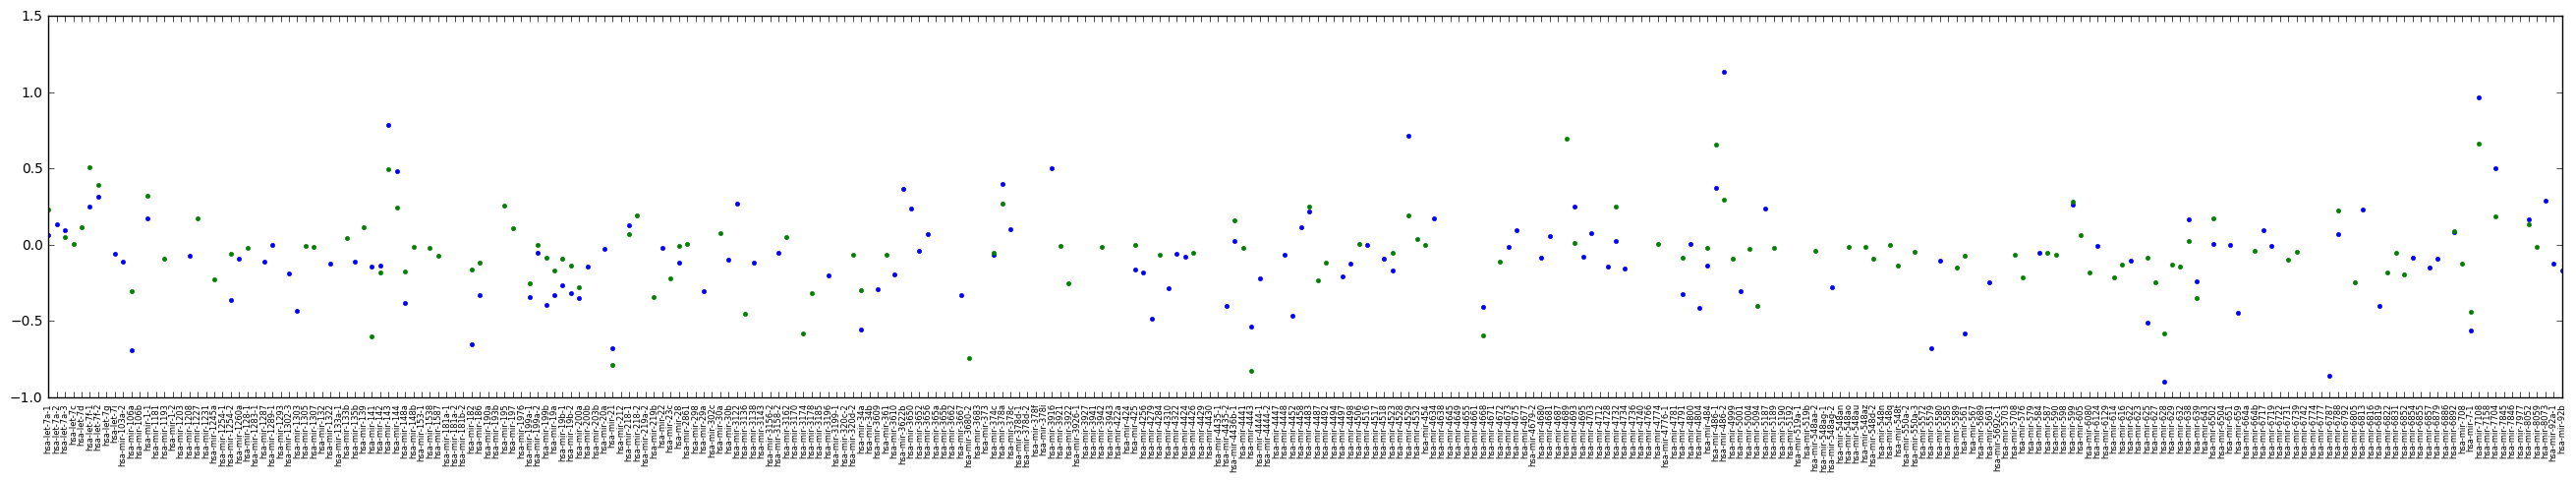

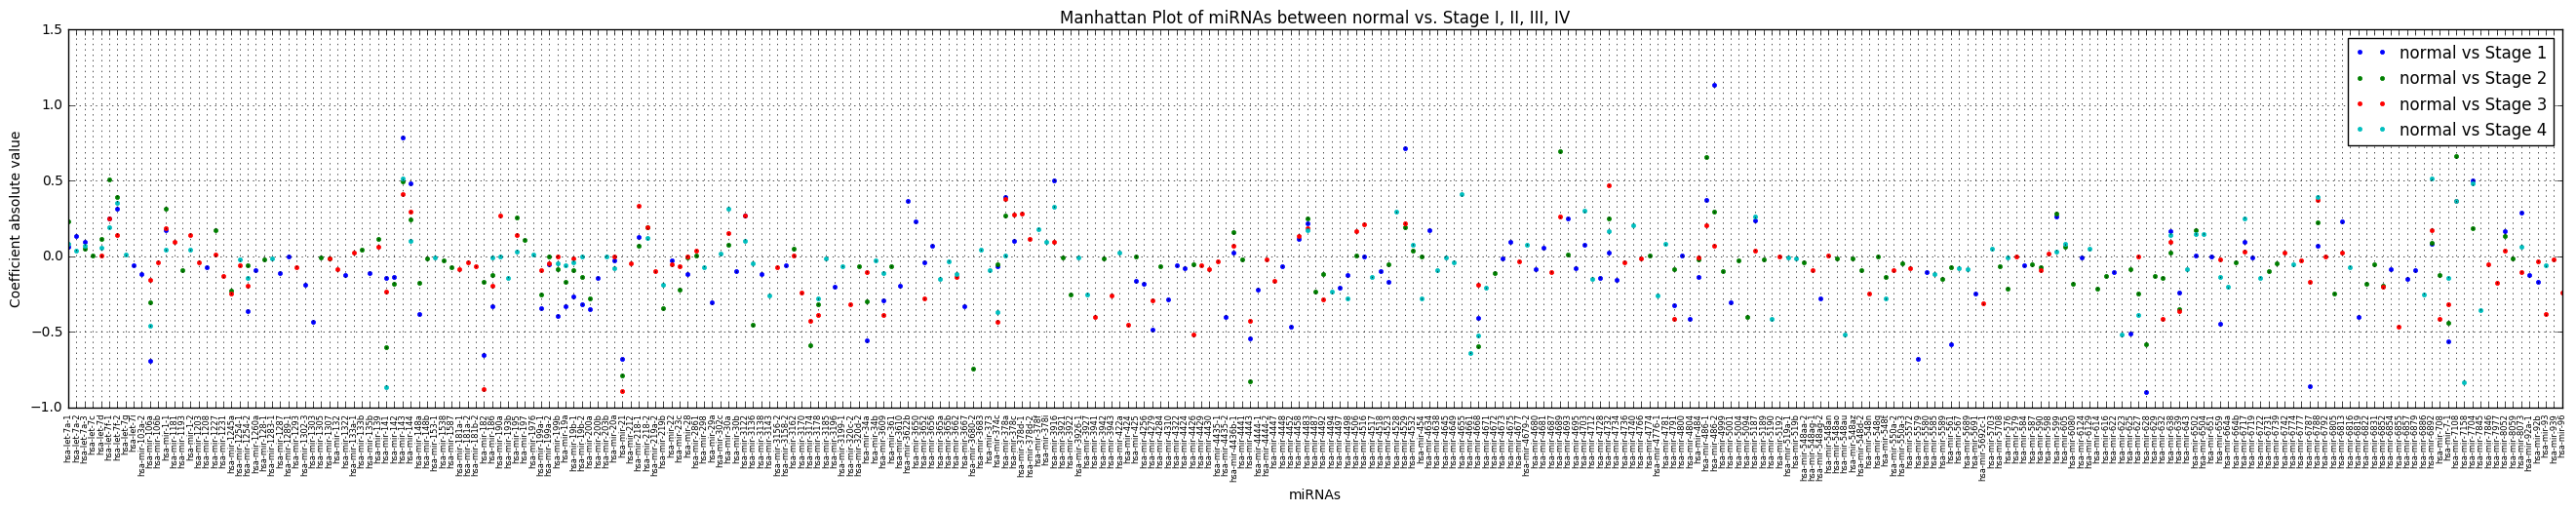

In [127]:
from matplotlib import pyplot as plt

all_candidate_miRNAs = set(results[0]['mirna']) | set(results[1]['mirna']) | set(results[2]['mirna']) | set(results[3]['mirna'])
sorted_candidate_miRNAs = []
for miR in mirna_list:
    if miR in all_candidate_miRNAs:
        sorted_candidate_miRNAs.append(miR)
print sorted_candidate_miRNAs.__len__()

plt.figure(figsize=(33, 5))
plt.xticks(range(sorted_candidate_miRNAs.__len__()), sorted_candidate_miRNAs, rotation='vertical', fontsize=6)

for i in [0,1,2,3]:
    x_indx = []
    y_values = []
    for x_str in results[i]['mirna']:
        # print all_candidate_miRNAs.index(x_str)
        x_indx.append(sorted_candidate_miRNAs.index(x_str))
    for y_value in results[i]['coefficient']:
        y_values.append(y_value)  
        
    # TODO add zeros values
        
    plt.plot(x_indx, y_values, marker='.', linestyle='', label='normal vs Stage '+str(i+1))

plt.legend()
plt.ylabel('Coefficient absolute value')
plt.xlabel('miRNAs')
plt.title('Manhattan Plot of miRNAs between normal vs. Stage I, II, III, IV')
plt.axis('auto')
plt.grid(True)
plt.show()